## loading data

In [7]:
# read the text file
import requests
import numpy as np

url = "https://arxiv.org/src/1604.07746v1/anc/sumofthreecubes_20160426.txt"
response = requests.get(url)
data = response.text

print("-------------------data up to 500 characters----------------------")
print(data[:500])  # Prints the content of the file


# transform into list format
lines = data.split('\n')
lines = lines[8:]

dataset = []
for line in lines :
    strdata = line.split()
    intdata = [int(x) for x in strdata]
    dataset.append(intdata)

print("-------------------transform into list----------------------")
print(dataset[:15])


# k, d, z format
dataset2 = [ [x[0],x[1]+x[3],x[2]] for x in dataset]
print("\n-------------------k,d,z format----------------------")
print(dataset2[:15])


# k, d format
dataset3 = [ [x[0],x[1]] for x in dataset2 ]
print("\n-------------------k,d format----------------------")
print(dataset3[:15])


# data range
print("\n-------------------k,d ranges----------------------")
print(max(dataset3,key = lambda x:x[1]))
print(np.log(max(dataset3,key = lambda x:x[1])[1]))
print(min(dataset3,key = lambda x:x[1]))
solution_list = set([tuple(x) for x in dataset3])

xydict = { tuple(x):1 for x in dataset3 }
print(f"number of data : {len(xydict)}")
klist = list(set([x[0] for x in dataset3]))
print(f"number of ks : {len(klist)}")

-------------------data up to 500 characters----------------------
List of solutions of x^3 + y^3 + z^3 = k for k < 1000
k not s^3 or 2*s^3 (s integer)
x, y, and z bounded up to 10^15
Sander G. Huisman 26-04-2016
Results combined with previous results.
------------------------------------------------
k x y z
------------------------------------------------
3 1 1 1
3 -5 4 4
6 -1 -1 2
6 -58 -43 65
6 -235 -55 236
6 -637 -205 644
6 -60355 10529 60248
6 -2593669 1426148 2441147
6 -5161892429569 3980702370479 4207039164926
6 -225522344776678 162765491944499 192722201
-------------------transform into list----------------------
[[3, 1, 1, 1], [3, -5, 4, 4], [6, -1, -1, 2], [6, -58, -43, 65], [6, -235, -55, 236], [6, -637, -205, 644], [6, -60355, 10529, 60248], [6, -2593669, 1426148, 2441147], [6, -5161892429569, 3980702370479, 4207039164926], [6, -225522344776678, 162765491944499, 192722201207819], [7, -1, 0, 2], [7, -105, 32, 104], [7, -169, 44, 168], [7, -680316, -605809, 812918], [7, -5575

In [8]:
import random
import math
random.seed(42)
# augment data
solution_list = list(xydict)
for i, x in enumerate(solution_list):
    k = x[0]
    d = x[1]
    for _ in range(1):
        new_d = int(random.uniform(0.8,1.2) * d)
        if new_d == 0 :
            new_d += random.choice([-1,1])*random.randint(1,5)

        if (k,new_d) not in xydict:
            xydict[(k,new_d)] = 0

print(f"total number of data : {len(xydict)}")


# make into input format
xylist = []
xylist2 = []
for key, val in xydict.items():
    k, d = key
    xylist2.append([[k,d],val])
    k = k/1000.0
    d = np.sign(d)*np.log(abs(d))/34
    xylist.append([[k,d],val])

# shuffle
random.seed(42)
random.shuffle(xylist)
random.shuffle(xylist2)

print("\n--------data examples--------")
print(xylist[:5])
print(xylist2[:5])

total number of data : 28244

--------data examples--------
[[[0.181, np.float64(0.8924772108401661)], 0], [[0.186, np.float64(-0.2747203251894479)], 1], [[0.668, np.float64(0.613507240249139)], 0], [[0.137, np.float64(-0.20172250102327544)], 0], [[0.434, np.float64(0.1650920031290609)], 0]]
[[[918, -10793], 0], [[988, 251], 0], [[312, -9308544097376], 1], [[71, -97], 0], [[845, 1018333], 0]]


## Supervised learning

In [9]:
# get dataset in right format
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# data
X = [xy[0] for xy in xylist]
y = [xy[1] for xy in xylist]

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
print(X_train[1:4],y_train[1:4])
print(X_test[1:4],y_test[1:4])

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add a dimension for compatibility
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Add a dimension for compatibility

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Input layer (2 dimensions) to hidden layer (10 units)
        self.fc2 = nn.Linear(10, 10)  # Input layer (2 dimensions) to hidden layer (10 units)
        self.fc3 = nn.Linear(10, 1)  # Hidden layer to output layer (1 unit)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation for hidden layer
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Sigmoid activation for output
        return x

# Instantiate the model
model = SimpleNN()

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(20000):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update parameters

    if (epoch + 1) % 2000 == 0:  # Print every 2000 epochs
        print(f'Epoch [{epoch + 1}/20k], Loss: {loss.item():.10f}')

print("Training completed!")

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_labels = (y_pred >= 0.5).float()  # Convert probabilities to binary labels
    print([[xx,yy,ypred] for xx,yy,ypred in zip(X_test[:30],y_test[:30],y_pred_labels[:30])])
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy on the test set: {accuracy:.4f}')

[[0.47, np.float64(0.6304033063906569)], [0.487, np.float64(0.5289807744603504)], [0.587, np.float64(0.5623918773495438)]] [0, 1, 0]
[[0.944, np.float64(0.5828180415269193)], [0.476, np.float64(-0.41059501833208806)], [0.376, np.float64(-0.02038668178117486)]] [1, 0, 1]
Epoch [2000/20k], Loss: 0.6851229072
Epoch [4000/20k], Loss: 0.6850469708
Epoch [6000/20k], Loss: 0.6850314736
Epoch [8000/20k], Loss: 0.6850281358
Epoch [10000/20k], Loss: 0.6850162745
Epoch [12000/20k], Loss: 0.6850180030
Epoch [14000/20k], Loss: 0.6850162745
Epoch [16000/20k], Loss: 0.6850164533
Epoch [18000/20k], Loss: 0.6850062013
Epoch [20000/20k], Loss: 0.6850139499
Training completed!
[[tensor([0.1440, 0.2752]), tensor([0.]), tensor([0.])], [tensor([0.9440, 0.5828]), tensor([1.]), tensor([0.])], [tensor([ 0.4760, -0.4106]), tensor([0.]), tensor([0.])], [tensor([ 0.3760, -0.0204]), tensor([1.]), tensor([1.])], [tensor([0.5400, 0.1468]), tensor([1.]), tensor([1.])], [tensor([0.7100, 0.7705]), tensor([1.]), tensor(

In [ ]:
k = klist[0]
d = 201111010105
print(k,d)
model.eval()
model(torch.tensor([k/1000,np.sign(d)*np.log(abs(d))/34], dtype=torch.float32))
# model(torch.tensor([k,d],dtype=torch.float32))

3 201111010105


tensor([0.4734], grad_fn=<SigmoidBackward0>)

## Plot known data

In [ ]:
dataset_XY = []
for x in dataset:
    if x[0] < 500 and x[2] > 50:
        if x[1]>0 and x[2]>0 and x[3]>0 :
            continue
        if x[2] > 0 :
            if x[1] == 0 :
                continue
            dataset_XY.append([-x[3]/x[1],-x[2]/x[1], np.log(-x[1])])
        else :
            if x[3] == 0 :
                continue
            dataset_XY.append([-x[1]/x[3],-x[2]/x[3], np.log(x[3])])
print(len(dataset))
print(len(dataset_XY))
print(dataset[:50])
print(dataset_XY[:50])

15254
3192
[[3, 1, 1, 1], [3, -5, 4, 4], [6, -1, -1, 2], [6, -58, -43, 65], [6, -235, -55, 236], [6, -637, -205, 644], [6, -60355, 10529, 60248], [6, -2593669, 1426148, 2441147], [6, -5161892429569, 3980702370479, 4207039164926], [6, -225522344776678, 162765491944499, 192722201207819], [7, -1, 0, 2], [7, -105, 32, 104], [7, -169, 44, 168], [7, -680316, -605809, 812918], [7, -5575582, 1374870, 5547575], [7, -6150123, 1124657, 6137561], [7, -17136136, 13010655, 14144042], [7, -132641670, -101429158, 150032039], [7, -2166785964, 1034817722, 2085067487], [7, -3374007862, 316143303, 3373082402], [7, -7657432774, -6427544172, 8940123359], [7, -26983077576, 9371950802, 26600822975], [7, -66447663334, 26361760320, 65034768671], [7, -267771290215, 83586276165, 265028377793], [7, -7101975822889, 4199422931672, 6574314162612], [7, -34807223588524, 10148032003454, 34517283607023], [7, -50427467704543, -3232871681403, 50431896357881], [7, -168218632243945, -61605392145082, 170928876351450], [9, 0, 

max : 34.82053908171518, min : 4.219507705176107


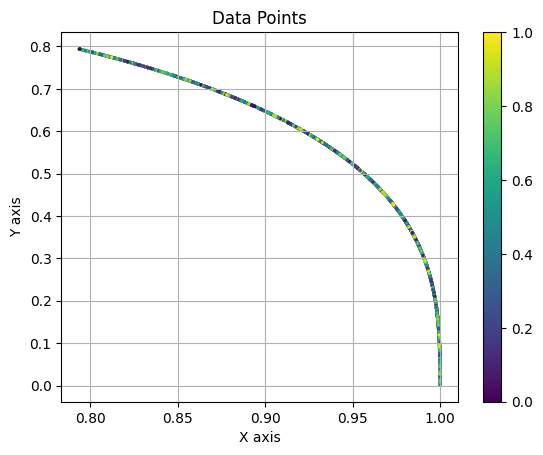

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Convert list of lists to numpy arrays
points = np.array(dataset_XY)
x = points[:, 0]  # All x coordinates
y = points[:, 1]  # All y coordinates

# Normalize the color component (third column)
colors = points[:, 2]
print(f"max : {np.max(colors)}, min : {np.min(colors)}")
normalized_colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

# Create scatter plot
plt.scatter(points[:, 0], points[:, 1],
           c=normalized_colors,
           s=2,
           cmap='viridis')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Data Points')
plt.colorbar()
plt.grid(True)
# plt.xlim(0.85, 0.90)    # Set x-axis range from -1 to 5
# plt.ylim(0.65, 0.75)    # Set y-axis range from -1 to 5
plt.show()


In [ ]:
dataset

[[3, 1, 1, 1],
 [3, -5, 4, 4],
 [6, -1, -1, 2],
 [6, -58, -43, 65],
 [6, -235, -55, 236],
 [6, -637, -205, 644],
 [6, -60355, 10529, 60248],
 [6, -2593669, 1426148, 2441147],
 [6, -5161892429569, 3980702370479, 4207039164926],
 [6, -225522344776678, 162765491944499, 192722201207819],
 [7, -1, 0, 2],
 [7, -105, 32, 104],
 [7, -169, 44, 168],
 [7, -680316, -605809, 812918],
 [7, -5575582, 1374870, 5547575],
 [7, -6150123, 1124657, 6137561],
 [7, -17136136, 13010655, 14144042],
 [7, -132641670, -101429158, 150032039],
 [7, -2166785964, 1034817722, 2085067487],
 [7, -3374007862, 316143303, 3373082402],
 [7, -7657432774, -6427544172, 8940123359],
 [7, -26983077576, 9371950802, 26600822975],
 [7, -66447663334, 26361760320, 65034768671],
 [7, -267771290215, 83586276165, 265028377793],
 [7, -7101975822889, 4199422931672, 6574314162612],
 [7, -34807223588524, 10148032003454, 34517283607023],
 [7, -50427467704543, -3232871681403, 50431896357881],
 [7, -168218632243945, -61605392145082, 170928876